# Taller 4  - Competencia: Clasificación de Peptidos Antimicrobianos

Se cuenta con una recopilación de bases de datos de *péptidos* de dos tipos: *antimicrobianos* y *No antimicrobianos*. Para cada conjunto de datos se tienen 1700 descriptores o características fisicoquímicas de los *péptidos*. 

El objetivo de este Notebook es realizar un proceso de clasificación de los péptidos de ambas clases empleando 3 métodos de clasificación: Regresión Logística, Bosque Aleatorio y Descenso de Gradiente Estocástico. Para ello se dividirá la base de datos en un 80% para entrenamiento y 20% para probar los modelos. 

El procedimiento de trabajo es el siguiente:
1. Se realizará el proceso de clasificación con todas las características, sin modificar los hyperparámetros.
2. Se empleará `GridSearch`, un método para ajustar hyperparámetros de manera automática. 
3. Se seleccionarán los hyperparámetros a utilizar para los siguientes pasos.
4. Se aplicará un proceso de eliminación de características recursivo para extraer las características más importantes.
5. Se aplicará un método de extracción de características.

En cada paso de medirán diferentes métricas para evaluar el desempeño de los clasificadores.


Los integrates del grupo son:
- Lina Victoria Parra Duque
- Janick Alberto Reales Salas
- Luisa Fernanda Rios Piedrahita



### Preparación de los datos

In [1]:
## Se importan algunas librerías requeridas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

Se procede a cargar las bases de datos de péptidos a emplear:

In [2]:
## Base de datos positivos (peptidos antimicrobianos)
positivos = pd.read_csv("DatosPositivos2.csv", index_col = 0)

## Base de datos negativos (peptidos no antimicrobianos)
negativos = pd.read_csv("DatosNegativos2.csv")

## Conjunto de validación
validacion = pd.read_csv("DatosValidacion2.csv", index_col = 0)

print(positivos.shape)
print(negativos.shape)
print(validacion.shape)

(8322, 1760)
(13679, 1760)
(1623, 1761)


In [3]:
## Verificamos las características contenidas en cada base de datos
print(positivos.columns)
print(negativos.columns)
print(validacion.columns)

Index(['sequence', 'length', 'molecular_weight', 'charge', 'charge_density',
       'isoelectric_point', 'gravy', 'instability_index', 'aromaticity',
       'aliphatic_index',
       ...
       'embed_2_91', 'embed_2_92', 'embed_2_93', 'embed_2_94', 'embed_2_95',
       'embed_2_96', 'embed_2_97', 'embed_2_98', 'embed_2_99', 'class'],
      dtype='object', length=1760)
Index(['sequence', 'length', 'molecular_weight', 'charge', 'charge_density',
       'isoelectric_point', 'gravy', 'instability_index', 'aromaticity',
       'aliphatic_index',
       ...
       'embed_2_91', 'embed_2_92', 'embed_2_93', 'embed_2_94', 'embed_2_95',
       'embed_2_96', 'embed_2_97', 'embed_2_98', 'embed_2_99', 'class'],
      dtype='object', length=1760)
Index(['Unnamed: 0.1', 'sequence', 'length', 'molecular_weight', 'charge',
       'charge_density', 'isoelectric_point', 'gravy', 'instability_index',
       'aromaticity',
       ...
       'embed_2_91', 'embed_2_92', 'embed_2_93', 'embed_2_94', 'embed_2_

El conjunto de datos de validación contiene una columba extra (Unnamed: 0.1) con los índices, por lo que se procede a eliminarla para que los tres conjuntos de datos cuenten con el mismo número de columnas. 

In [4]:
## Se elimina columna con índice de datos de validación

validacion = validacion.iloc[:, 1:]
print(validacion.shape)
validacion.head()

(1623, 1760)


,sequence,length,molecular_weight,charge,charge_density,isoelectric_point,gravy,instability_index,aromaticity,aliphatic_index,...,embed_2_91,embed_2_92,embed_2_93,embed_2_94,embed_2_95,embed_2_96,embed_2_97,embed_2_98,embed_2_99,class
0,VVCACRRALCLPRERRAGFCRIRGRIHPLCCRR,33,3897.77,8.691,0.002230,11.404358,-0.112121,84.766667,0.030303,85.757576,...,2.771416,-0.851930,-0.459909,0.909622,1.402783,-3.848056,-0.528822,-0.740751,-0.257650,1
1,GICACRRRFCPNSERFSGYCRVNGARYVRCCSRR,34,4003.64,7.590,0.001896,10.196106,-0.638235,76.035294,0.117647,34.411765,...,2.356963,-0.590644,-0.433246,0.362768,1.204798,-3.838024,-0.859893,-1.086264,0.052278,1
2,LRDLVCYCRSRGCKGRERMNGTCRKGHLLYTLCCR,35,4121.92,6.689,0.001623,9.611023,-0.551429,16.851429,0.057143,64.000000,...,2.762231,-1.182640,-0.908285,0.802487,1.546229,-4.543212,-0.786475,-0.477468,-0.178319,1
3,RRCICTTRTCRFPYRRLGTCIFQNRVYTFCC,31,3838.56,6.589,0.001717,9.802917,-0.200000,53.977419,0.161290,47.096774,...,1.742604,-0.981736,-0.098695,0.614634,0.774174,-2.818301,-0.395545,-0.738405,0.369630,1
4,VCSCRLVFCRRTELRVGNCLIGGVSFTYCCTRV,33,3715.45,3.591,0.000967,8.981384,0.660606,62.042424,0.090909,91.212121,...,1.734715,-0.830263,-0.386610,0.836167,0.859871,-3.665342,-0.922017,-0.364447,-0.055827,1


Lo siguiente a hacer es unir las bases de datos en una sola llamada "*database*", para posteriormente separar la primera columna, la cual contiene los nombres de cada secuencia de péptidos y no es relevate para el proceso de clasificación. 

In [5]:
## se concatenan las bases

database = pd.concat([positivos, negativos, validacion], axis = 0)

In [6]:
# se elimina columna de texto:

sequence = database['sequence']
database = database.iloc[:, 1:]
database.shape

(23624, 1759)

Miremos cómo se encuentra distribuídas las clases de péptidos en la base de datos.

In [7]:
## Distribución de las clases de peptidos contenidas en la base de datos.

database['class'].value_counts()

0    15033
1     8591
Name: class, dtype: int64

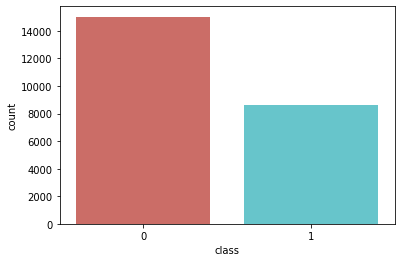

In [8]:
import seaborn as sns

sns.countplot(x='class', data=database, palette='hls')
plt.show()

Nuestra base de datos está compuesta en casi un 63% de péptidos no antrimicrobianos (class = 0) y 37% de péptidos microbianos (class = 1). 

Ahora separamos la columna '*class*' del conjunto de características para aplicar un proceso de *normalización* sobre este último. Con esta normalización queremos llevar todas las características a una misma escala, que permita un mejor desempeño de los modelos.

In [9]:
# Se divide la base de datos

data = database.drop(['class'], axis=1) # conjunto de carasterísticas
columnas = data.columns      # nombres de las columnas/características
target = database['class']   # clase de los péptidos

In [10]:
## Se aplica normalización sobre el conjunto de características

data_norm = preprocessing.normalize(data, norm='l2', axis=0)

In [11]:
# Se crea un dataframe con el conjunto de características normalizado:

data = pd.DataFrame(data_norm, columns=columnas)
data.head()

,length,molecular_weight,charge,charge_density,isoelectric_point,gravy,instability_index,aromaticity,aliphatic_index,boman_index,...,embed_2_90,embed_2_91,embed_2_92,embed_2_93,embed_2_94,embed_2_95,embed_2_96,embed_2_97,embed_2_98,embed_2_99
0,0.006130,0.005887,0.010263,0.010246,0.007871,-0.009469,0.008451,0.006390,0.000000,0.009508,...,-0.003859,0.004634,0.001525,-0.002609,0.007585,0.003990,-0.005448,-0.000517,-0.008588,0.001712
1,0.005162,0.004815,0.006535,0.007977,0.008063,0.006413,0.002421,0.000000,0.010008,-0.002086,...,-0.001741,0.003078,-0.007457,-0.005970,-0.001380,-0.001512,-0.003999,-0.005291,-0.003582,-0.002984
2,0.005485,0.005955,0.010550,0.010414,0.009411,-0.004293,0.004986,0.009523,0.003307,0.004552,...,-0.001257,0.005854,0.005131,-0.001131,0.013715,0.012943,-0.009549,-0.006825,-0.006487,0.005322
3,0.006453,0.006128,0.004216,0.004044,0.008480,0.003143,0.001968,0.004047,0.008327,0.001710,...,-0.006106,0.008723,-0.000233,-0.006760,0.011987,0.008103,-0.006340,-0.005677,-0.006845,0.006009
4,0.008066,0.007743,0.001172,0.000890,0.006037,0.002832,0.003619,0.003238,0.002220,0.002960,...,-0.013453,0.007337,-0.016623,0.000291,0.008107,0.017724,-0.010720,-0.009756,-0.016503,-0.000963


A continuación, procedemos a dividir el conjunto de datos en datos en un 80% para entrenamiento y 20% para prueba.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=0)

Ahora cargamos los modelos que vamos a emplear para la clasificación de los datos, además del método de Validación Cruzada, con el cual prodeceremos a medir el desempeño de los clasificadores en el conjunto de entrenamiento.

###  Clasificación con todas las características


In [14]:
## se cargan los modelos

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

Entrenamos los tres modelos con los datos de entrenamiento y empleamos validación cruzada, dividiendo el modelo en 5 partes o folds (cv=5). El método de validación cruzada entrena cada modelo con *k-1* folds y lo valida con el fold restante, midiendo la precisión en cada paso. Los rendimientos que se imprimen a continuación son el promedio obtenido al aplicar validación cruzada (5 folds), con cada modelo, sobre la base de datos de entrenamiento.


In [14]:
# Se ajusta el modelo de Regresión Logística (lr) a los datos y se mide el rendimiento promedio
lr = LogisticRegression() 
lr.fit(X_train, y_train)

score = cross_val_score(lr, X_train, y_train, cv=5) 
print("Se obtiene un rendimiento de {0:.1%} con Regresión Logística".format(score.mean()))


## Entrenamos el modelo de Bosque Aleatorio y medimos el rendimiento promedio
rf = RandomForestClassifier()  
rf.fit(X_train, y_train)

score = cross_val_score(rf, X_train, y_train, cv=5)
print("Se obtiene un rendimiento de {0:.1%} con Random Forest".format(score.mean()))


## Entrenamos el modelo de Descenso del Gradiente Estocástico y medimos el rendimiento promedio
sgd = linear_model.SGDClassifier() 
sgd.fit(X_train, y_train)

score = cross_val_score(sgd, X_train, y_train, cv=5)
print("Se obtiene un redimiento de {0:.1%} con SGD".format(score.mean()))

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

Se obtiene un rendimiento de 84.6% con Regresión Logística


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Se obtiene un rendimiento de 87.4% con Random Forest
Se obtiene un redimiento de 85.1% con SGD


Observamos que al entrenar los modelos sin realizar modificaciones a sus hyperparámetros se obtiene un mayor rendimiento en el conjunto de entrenamiento con el modelo de Bosque Aleatorio (87,4%), seguido del de Regresión Logística (84.6%) y por último SGD (85.1%). 

Utilizamos las métricas precision, recall, F1-score y confusion matrix para medir el desempeño de los clasifidores en el conjunto de prueba. 

La **matriz de confusión** nos compara las predicciones con los datos reales, donde cada columna de la matriz representa el número de predicciones de cada clase, mientras que las filas representan la clase real. El **precision** nos mide la capacidad del clasificador para no clasificar como positiva una muestra negativa (tp/tp+fp). El **recall** mide la capacidad del clasificador para clasificar las muestras positivas (tp/tp+fn). El **f1-score** es el promedio balaceado entre *precision* y *recall* (2x(precicion x recall)/(precision+recall))


In [15]:
## Evaluación de los clasificadores
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

##Precision
lr_score = precision_score(y_test, lr.predict(X_test))
rf_score = precision_score(y_test, rf.predict(X_test))
sgd_score = precision_score(y_test, sgd.predict(X_test))

print("Se obtiene una precisión de {0:.1%} con Regresión Logística".format(lr_score))
print("Se obtiene una precisión de {0:.1%} con Random Forest".format(rf_score))
print("Se obtiene una precisión de {0:.1%} con SGD\n".format(sgd_score))


##Recall
lr_score = recall_score(y_test, lr.predict(X_test))
rf_score = recall_score(y_test, rf.predict(X_test))
sgd_score = recall_score(y_test, sgd.predict(X_test))

print("Se obtiene un recall de {0:.1%} con Regresión Logística".format(lr_score))
print("Se obtiene un recall de {0:.1%} con Random Forest".format(rf_score))
print("Se obtiene un recall de {0:.1%} con SGD\n".format(sgd_score))


##F1_score
lr_score = f1_score(y_test, lr.predict(X_test))
rf_score = f1_score(y_test, rf.predict(X_test))
sgd_score = f1_score(y_test, sgd.predict(X_test))

print("Se obtiene un F1-score de {0:.1%} con Regresión Logística".format(lr_score))
print("Se obtiene un F1-score de {0:.1%} con Random Forest".format(rf_score))
print("Se obtiene un F1-score de {0:.1%} con SGD".format(sgd_score))


Se obtiene una precisión de 92.6% con Regresión Logística
Se obtiene una precisión de 92.4% con Random Forest
Se obtiene una precisión de 93.4% con SGD

Se obtiene un recall de 65.0% con Regresión Logística
Se obtiene un recall de 73.8% con Random Forest
Se obtiene un recall de 65.7% con SGD

Se obtiene un F1-score de 76.3% con Regresión Logística
Se obtiene un F1-score de 82.1% con Random Forest
Se obtiene un F1-score de 77.1% con SGD


In [16]:
from sklearn.metrics import confusion_matrix

#Confusion matrix
lr_cf = confusion_matrix(y_test, lr.predict(X_test))
print("Matriz de confusión Regresión Lineal:\n", lr_cf, "\n")

rf_cf = confusion_matrix(y_test, rf.predict(X_test))
print("Matriz de confusión Random Forest:\n", rf_cf, "\n")

sgd_cf = confusion_matrix(y_test, sgd.predict(X_test))
print("Matriz de confusión SGD:\n", sgd_cf)

Matriz de confusión Regresión Lineal:
 [[2903   90]
 [ 607 1125]] 

Matriz de confusión Random Forest:
 [[2888  105]
 [ 454 1278]] 

Matriz de confusión SGD:
 [[2912   81]
 [ 594 1138]]


Observaciones:
- El modelo de Descenso de Gradiente Estocástico mostró un desempeño ligeramente superior, de acuerdo con la métrica de *Precision*. Sin embargo, su rendimiento es el más bajo, tomando en cuenta los resultados obtenidos para el Recall y el F1-score. Indicando así que este modelo cumple un buen papel a la hora de clasificar a los *péptidos No-antimicrobianos* en su categoría correcta, y que no es tan bueno cuando se trata de clasificar a los *péptidos antimicrobianos*. Se puede constatar esto al mirar su matriz de confusión.
- De acuerdo con el *Precision*, los métodos de Regresión Logística y Random Forest presentaron un rendimiento similar (con los hyperparámetros por defecto). Mientras que ambos modelos difieren en las métricas de *recall* y *f1-score*. Indicando que la capacidad del modelo de Regresión logística es similar a la del modelo de Bosque Aleatorio a la hora de no clasificar Péptidos No-Antimicrobianos como Péptidos Antimicrioanos. Sin embargo, el modelo de Bosque aleatorio se comporta mejor para clasificar los péptidos antimicrobianos en su categoría correcta.

### Ajustando los Hyperparámetros

Para este caso usaremos el método **GridSearchCV** de Scikit-Learn, al cual podemos pasar un conjunto de valores para cada hyperparámetro. Este método construye y evalúa cada modelo con diferentes combinaciones para cada hyperparámetro.


In [39]:
# Importamos la librería a utilizar

from sklearn.model_selection import GridSearchCV

Procedemos ahora a definir nuestro "grid", el cual vamos a pasar a GridSearch, con los hyperparámetros con los que queremos probar cada modelo. 

##### Regresión Logística:

Para este modelo se decidió ajustar los hyperparámetros de **'penalty'**, con el cual podemos definir el tipo de normalización que queremos implementar sobre los datos del modelo; la idea de la normalización **l1** es que la sumatoria de los valores absolutos sea unitaria, mientras que la normalización **'l2'** busca que la sumatoria de los cuadrados sea unitaria. **'C'**, que es el inverso de la fuerza de regularización (la cual nos ayuda a evitar el sobre-ajuste en nuestros modelos); es decir, entre menor sea el valor de C, mayor es la regularización aplicada al modelo. **'Solver'** con el cual definimos el algotitmo de optimización a implementar. 

In [40]:
# Definiendo el grid para la regresión logística

lr = LogisticRegression()
penalty=['l1', 'l2']
C=[500, 100, 50, 1, 0.1, 0.01]
solver= ['liblinear', 'saga']

## Definimos el diccionario con los parámetros
param_grid = dict(penalty=penalty, C=C, solver=solver)

## Ingresamos los parámetros
grid = GridSearchCV(estimator=lr,
                    param_grid=param_grid,
                    scoring='roc_auc',
                    n_jobs=-1)

## Ajustamos a los datos de entrenamiento
grid_result = grid.fit(X_train, y_train)

print("Se tiene un Score de %f utilizando %s" % (grid_result.best_score_, grid_result.best_params_))

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Se tiene un Score de 0.939646 utilizando {'C': 50, 'penalty': 'l1', 'solver': 'liblinear'}


Calculamos la métrica Score de GridSearchCV sobre el conjunto de entrenamiento, la cual nos indica el mayor rendimiento alcanzado sobre el conjunto de entrenamiento, además de que imprimimos la combinación de hyperparámetros requerida para alcanzar dicho rendimiento. Para este modelo tenemos que alzanza su óptimo con C=50, Penalty = 'l1' y solver='liblinear'. 

##### Bosque Aleatorio:

En este caso se decidió variar los hyperparámetros **'n_estimator'**, con el cuál definimos el número de árboles en el modelo, y **'max_features'** con el cual definimos el número de caracteríticas a considerar cada vez que se vaya a hacer una partición en el árbol. Es decir, cada que se vaya a hacer una partición, se seleccionan N características aleatorias y se selecciona cuál es la mejor para dicho nodo. 

In [27]:
# Definiendo el grid para bosque aleatorio

rf=RandomForestClassifier()
n_estimators=list(range(10,100,20))
max_features=list(range(6,32,5))

## Definimos el diccionario con los parámetros
param_grid = dict(n_estimators=n_estimators, max_features=max_features)

## Ingresamos los parámetros
grid = GridSearchCV(estimator=rf,
                    param_grid=param_grid,
                    scoring='roc_auc',
                    n_jobs=-1)

## Ajustamos a los datos de entrenamiento
grid_result = grid.fit(X_train, y_train)

print("Se tiene un Score de %f utilizando %s" % (grid_result.best_score_, grid_result.best_params_))

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best: 0.944403 using {'max_features': 26, 'n_estimators': 90}
Execution time: 473.596732378006 ms


Donde obtenemos el mayor rendimiento sobre el conjunto de entrenamiento al seleccionar un máximo de 26 características para cada partición y 90 árboles en el modelo.

##### Descenso de Gradiente Estocástico: 

En este caso ajustamos los hyperparámetros **'penalty'**, definido anteriormente, y **'loss'**, con el cual definimso la función de pérdida o costo a utilizar: *hinge* es la función por defecto, y es utilizada para clasificación del margen-máximo entre los datos de las diferentes clases, mientras que *squared_hinge* cumple el mismo papel que la primera, pero con una función cuadrática. 

In [21]:
# Definiendo el grid para SGD

sgd = linear_model.SGDClassifier()
penalty = ['l1', 'l2']
loss = ['hinge', 'squared_hinge']

## Definimos el diccionario con los parámetros
param_grid = dict(penalty=penalty, loss=loss)

## Ingresamos los parámetros
grid = GridSearchCV(estimator=sgd,
                    param_grid=param_grid,
                    scoring='roc_auc',
                    n_jobs=-1)

## Ajustamos a los datos de entrenamiento
grid_result = grid.fit(X_train, y_train)

print("Se tiene un Score de %f utilizando %s" % (grid_result.best_score_, grid_result.best_params_))


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Se tiene un Score de 0.917105 utilizando {'loss': 'squared_hinge', 'penalty': 'l2'}


De acuerdo con los resultados, tenemos un mayor rendimiento al definir loss = 'squared_hinge'´y penalty = 'l2'. 

### Probamos cada modelo con los Hyperparámetros seleccionados

Apliquemos validación cruzadasobre los datos de entrenamiento:

In [22]:
# Se ajusta el modelo de Regresión Logística (lr) a los datos y se mide el rendimiento promedio
lr = LogisticRegression(C=50, penalty='l1', solver='liblinear') 
lr.fit(X_train, y_train)

score = cross_val_score(lr, X_train, y_train, cv=5) 
print("Se obtiene un rendimiento de {0:.1%} con Regresión Logística".format(score.mean()))


## Entrenamos el modelo de Bosque Aleatorio y medimos el rendimiento promedio
rf = RandomForestClassifier(max_features=26, n_estimators=90)  
rf.fit(X_train, y_train)

score = cross_val_score(rf, X_train, y_train, cv=5)
print("Se obtiene un rendimiento de {0:.1%} con Random Forest".format(score.mean()))


## Entrenamos el modelo de Descenso del Gradiente Estocástico y medimos el rendimiento promedio
sgd = linear_model.SGDClassifier(loss='squared_hinge', penalty='l2') 
sgd.fit(X_train, y_train)

score = cross_val_score(sgd, X_train, y_train, cv=5)
print("Se obtiene un redimiento de {0:.1%} con SGD".format(score.mean()))

Se obtiene un rendimiento de 88.4% con Regresión Logística
Se obtiene un rendimiento de 89.6% con Random Forest


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Usuario\Anaconda3\lib\site-

Se obtiene un redimiento de 84.6% con SGD


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


En este caso se obtivo una mejora en rendimiento del 3.8% para el modelo de Regresión Logrística y 2.2% para el modelo de Bosque Aleatorio, mientras que el rendimiento del Descenso de Gradiente Estocástico fue ligeramente más bajo. 

Ahora procedemos a medir las métricas de rendimiento nuevamente y comparamos con las obtenidas para los modelos base:

In [23]:
## Evaluación de los clasificadores
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

##Precision
lr_score = precision_score(y_test, lr.predict(X_test))
rf_score = precision_score(y_test, rf.predict(X_test))
sgd_score = precision_score(y_test, sgd.predict(X_test))

print("Se obtiene una precisión de {0:.1%} con Regresión Logística".format(lr_score))
print("Se obtiene una precisión de {0:.1%} con Random Forest".format(rf_score))
print("Se obtiene una precisión de {0:.1%} con SGD\n".format(sgd_score))


##Recall
lr_score = recall_score(y_test, lr.predict(X_test))
rf_score = recall_score(y_test, rf.predict(X_test))
sgd_score = recall_score(y_test, sgd.predict(X_test))

print("Se obtiene un recall de {0:.1%} con Regresión Logística".format(lr_score))
print("Se obtiene un recall de {0:.1%} con Random Forest".format(rf_score))
print("Se obtiene un recall de {0:.1%} con SGD\n".format(sgd_score))


##F1_score
lr_score = f1_score(y_test, lr.predict(X_test))
rf_score = f1_score(y_test, rf.predict(X_test))
sgd_score = f1_score(y_test, sgd.predict(X_test))

print("Se obtiene un F1-score de {0:.1%} con Regresión Logística".format(lr_score))
print("Se obtiene un F1-score de {0:.1%} con Random Forest".format(rf_score))
print("Se obtiene un F1-score de {0:.1%} con SGD".format(sgd_score))

Se obtiene una precisión de 86.5% con Regresión Logística
Se obtiene una precisión de 94.9% con Random Forest
Se obtiene una precisión de 79.8% con SGD

Se obtiene un recall de 82.9% con Regresión Logística
Se obtiene un recall de 75.8% con Random Forest
Se obtiene un recall de 81.4% con SGD

Se obtiene un F1-score de 84.7% con Regresión Logística
Se obtiene un F1-score de 84.3% con Random Forest
Se obtiene un F1-score de 80.6% con SGD


In [24]:
from sklearn.metrics import confusion_matrix

#Confusion matrix
lr_cf = confusion_matrix(y_test, lr.predict(X_test))
print("Matriz de confusión Regresión Lineal:\n", lr_cf, "\n")

rf_cf = confusion_matrix(y_test, rf.predict(X_test))
print("Matriz de confusión Random Forest:\n", rf_cf, "\n")

sgd_cf = confusion_matrix(y_test, sgd.predict(X_test))
print("Matriz de confusión SGD:\n", sgd_cf)

Matriz de confusión Regresión Lineal:
 [[2769  224]
 [ 296 1436]] 

Matriz de confusión Random Forest:
 [[2923   70]
 [ 419 1313]] 

Matriz de confusión SGD:
 [[2635  358]
 [ 322 1410]]


Observaciones:
- El modelo de Regresión Logística presenta una disminución del 6% en su rendimiento de acuerdo con la métrica *precision*, sin embargo muestra una mejora significativa para la métrica de *recall* y un mejor rendimiento de acuerdo con el *f1-score*. Esto quiere decir que con la combinación de hyperparámetros seleccionada logramos que el modelo realice un mejor trabajo para clasificar los *péptidos antimicrobianos* en su categoría correcta, sacrificando un poco su desempeño a la hora de no clasificar *péptidos no-antimicrobianor* como antimicrobianos (mirar matriz de confusión).
- El modelo de Bosque Aleatorio obtuvo una mejora del 2% al comparar el modelo Base y el modelo con los hyperparámetros ajustados para las métrica *precision*, *recall* y *f1-score*, que se puede constatar si miramos la matriz de confusión donde se nos muestra, con los hyperparámetros seleccionados, el modelo realiza mejor el proceso de clasificación.  
- Al igual que el modelo de Regresión Logística, con el modelo de Descenso de Gradiente Estocástico obtenemos una mejora a la hora de clasificar los *péptidos antimicrobianos* en su categoría correcta de acuerdo con el *recall*, sin embargo, el desempeño del modelo para clasificar los *péptidos no-antimicrobianos* dentro de su categoría se ve disminuído, de acuerdo con el *precision* y la *matriz de confusión*. 


### Aplicando selección de características

A continuación se aplica un método de selección de carasterísticas sobre los datos y luego se miden las métricas para cada modelo con los hyperparámetros determinados en el paso anterior. Esto con el objetivo de identificar si seleccionar las características principales significa una mejora en la capacidad de clasificación de los modelos. 

Para ello se utiliza un Eliminador de Características Recursivo, *RFE*, por sus siglas en inglés, al cual se le ingresa el número de características máximo que queremos seleccionar. 


De manera aleatoria se ha decidido probar cada modelo al seleccionar 1000, 500 y 100 características. En cada caso se mide el *Accuracy* con objetivo de comparar el desempeño de los modelos.

#### RFE con Regresión Logística

Seleccionando 1000 características

In [17]:
from sklearn.feature_selection import RFE

# se crea modelo con Regresión Logística y se seleccionan 1000 características, eliminando 100 a cada paso
lr = LogisticRegression(C=50, penalty='l1', solver='liblinear') 
rfe_lr1 = RFE(estimator=lr, n_features_to_select=1000, step = 100, verbose=1)

#Ajustando modelo a datos
rfe_lr1.fit(X_train, y_train)

#calculamos el accuracy

acc = accuracy_score(y_test, rfe_lr1.predict(X_test))
print("{0:.1%} accuracy on test set.".format(acc)) 

Fitting estimator with 1758 features.
Fitting estimator with 1658 features.
Fitting estimator with 1558 features.
Fitting estimator with 1458 features.
Fitting estimator with 1358 features.
Fitting estimator with 1258 features.
Fitting estimator with 1158 features.
Fitting estimator with 1058 features.
88.9% accuracy on test set.


Seleccionando 500 características

In [18]:
# se crea modelo con Regresión Logística y se seleccionan 500 características, eliminando 200 a cada paso. 
rfe_lr2 = RFE(estimator=lr, n_features_to_select=500, step = 200, verbose=1)

#Ajustando modelo a datos
rfe_lr2.fit(X_train, y_train)

#calculamos el accuracy

acc = accuracy_score(y_test, rfe_lr2.predict(X_test))
print("{0:.1%} accuracy on test set.".format(acc)) 

Fitting estimator with 1758 features.
Fitting estimator with 1558 features.
Fitting estimator with 1358 features.
Fitting estimator with 1158 features.
Fitting estimator with 958 features.
Fitting estimator with 758 features.
Fitting estimator with 558 features.
89.3% accuracy on test set.


Seleccionando 100 características

In [19]:
# se crea modelo con Regresión Logística y se seleccionan 1000 características
rfe_lr3 = RFE(estimator=lr, n_features_to_select=100, step = 300, verbose=1)

#Ajustando modelo a datos
rfe_lr3.fit(X_train, y_train)

#calculamos el accuracy

acc = accuracy_score(y_test, rfe_lr3.predict(X_test))
print("{0:.1%} accuracy on test set.".format(acc)) 

Fitting estimator with 1758 features.
Fitting estimator with 1458 features.
Fitting estimator with 1158 features.
Fitting estimator with 858 features.
Fitting estimator with 558 features.
Fitting estimator with 258 features.
87.8% accuracy on test set.


No se presenta un cambio muy significativo en la exactitud del modelo al seleccionar 1000, 500 o 100 características, siendo el mayor accuracy (89.3%) el alcanzado con 500 características seleccionadas. 

#### RFE con modelo de Bosque Aleatorio

Seleccionando 1000 características

In [20]:
# se crea modelo con Random Forest y se seleccionan 1000 características, eliminando 100 a cada paso
rf = RandomForestClassifier(max_features=26, n_estimators=90) 
rfe_rf1 = RFE(estimator=rf, n_features_to_select=1000, step = 100, verbose=1)

#Ajustando modelo a datos
rfe_rf1.fit(X_train, y_train)

#calculamos el accuracy

acc = accuracy_score(y_test, rfe_rf1.predict(X_test))
print("{0:.1%} accuracy on test set.".format(acc)) 

Fitting estimator with 1758 features.
Fitting estimator with 1658 features.
Fitting estimator with 1558 features.
Fitting estimator with 1458 features.
Fitting estimator with 1358 features.
Fitting estimator with 1258 features.
Fitting estimator with 1158 features.
Fitting estimator with 1058 features.
89.9% accuracy on test set.


Seleccionando 500 características

In [21]:
# se crea modelo con Random Forest y se seleccionan 500 características, eliminando 200 a cada paso
rfe_rf2 = RFE(estimator=rf, n_features_to_select=500, step = 200, verbose=1)

#Ajustando modelo a datos
rfe_rf2.fit(X_train, y_train)

#calculamos el accuracy

acc = accuracy_score(y_test, rfe_rf2.predict(X_test))
print("{0:.1%} accuracy on test set.".format(acc)) 

Fitting estimator with 1758 features.
Fitting estimator with 1558 features.
Fitting estimator with 1358 features.
Fitting estimator with 1158 features.
Fitting estimator with 958 features.
Fitting estimator with 758 features.
Fitting estimator with 558 features.
90.0% accuracy on test set.


Seleccionando 100 características

In [22]:
# se crea modelo con Random Forest y se seleccionan 100 características, eliminando 300 a cada paso
rfe_rf3 = RFE(estimator=rf, n_features_to_select=100, step = 300, verbose=1)

#Ajustando modelo a datos
rfe_rf3.fit(X_train, y_train)

#calculamos el accuracy

acc = accuracy_score(y_test, rfe_rf3.predict(X_test))
print("{0:.1%} accuracy on test set.".format(acc)) 

Fitting estimator with 1758 features.
Fitting estimator with 1458 features.
Fitting estimator with 1158 features.
Fitting estimator with 858 features.
Fitting estimator with 558 features.
Fitting estimator with 258 features.
90.3% accuracy on test set.


La mayor exactitud del modelo de Bosque Aleatorio se obtiene al seleccionar 100 carafcterísticas del total, arrojando un accurary=90.3%, no muy superior al obtenido con 1000 y 500 características seleccionadas.

#### RFE con Descenso de Gradiente Estocástico

Seleccionando 1000 características

In [23]:
# se crea modelo con SGD y se seleccionan 1000 características, eliminando 100 a cada paso
sgd = linear_model.SGDClassifier(loss='squared_hinge', penalty='l2') 
rfe_sgd1 = RFE(estimator=sgd, n_features_to_select=1000, step = 100, verbose=1)

#Ajustando modelo a datos
rfe_sgd1.fit(X_train, y_train)

#calculamos el accuracy

acc = accuracy_score(y_test, rfe_sgd1.predict(X_test))
print("{0:.1%} accuracy on test set.".format(acc)) 

Fitting estimator with 1758 features.


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Fitting estimator with 1658 features.


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Fitting estimator with 1558 features.


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Fitting estimator with 1458 features.


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Fitting estimator with 1358 features.


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Fitting estimator with 1258 features.


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Fitting estimator with 1158 features.


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Fitting estimator with 1058 features.


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


86.1% accuracy on test set.


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Seleccionando 500 características

In [24]:
# se crea modelo con SGD y se seleccionan 500 características, eliminando 200 a cada paso
rfe_sgd2 = RFE(estimator=sgd, n_features_to_select=500, step = 200, verbose=1)

#Ajustando modelo a datos
rfe_sgd2.fit(X_train, y_train)

#calculamos el accuracy

acc = accuracy_score(y_test, rfe_sgd2.predict(X_test))
print("{0:.1%} accuracy on test set.".format(acc)) 

Fitting estimator with 1758 features.


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Fitting estimator with 1558 features.


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Fitting estimator with 1358 features.


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Fitting estimator with 1158 features.


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Fitting estimator with 958 features.


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Fitting estimator with 758 features.


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Fitting estimator with 558 features.


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


86.3% accuracy on test set.


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Seleccionando 100 características

In [25]:
# se crea modelo con SGD y se seleccionan 100 características, eliminando 300 a cada paso
rfe_sgd3 = RFE(estimator=sgd, n_features_to_select=100, step = 300, verbose=1)

#Ajustando modelo a datos
rfe_sgd3.fit(X_train, y_train)

#calculamos el accuracy

acc = accuracy_score(y_test, rfe_sgd3.predict(X_test))
print("{0:.1%} accuracy on test set.".format(acc)) 

Fitting estimator with 1758 features.


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Fitting estimator with 1458 features.


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Fitting estimator with 1158 features.


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Fitting estimator with 858 features.


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Fitting estimator with 558 features.


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Fitting estimator with 258 features.


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


84.8% accuracy on test set.


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


En este caso se alcanzó un *accuracy* similar al seleccionar 1000 y 500 características, mientras que el mismo disminuyó al seleccionar solo 100 características del total.

Tomamos los casos en que se tuvo un mejor accuracy en cada modelo para medir las métricas de *precision*, *recall*, *f1-score* y *confusion matrix*.

In [26]:
## Evaluación de los clasificadores
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

##Precision
lr_score = precision_score(y_test, rfe_lr2.predict(X_test))
rf_score = precision_score(y_test, rfe_rf3.predict(X_test))
sgd_score = precision_score(y_test, rfe_sgd2.predict(X_test))

print("Se obtiene una precisión de {0:.1%} con Regresión Logística".format(lr_score))
print("Se obtiene una precisión de {0:.1%} con Random Forest".format(rf_score))
print("Se obtiene una precisión de {0:.1%} con SGD\n".format(sgd_score))


##Recall
lr_score = recall_score(y_test, rfe_lr2.predict(X_test))
rf_score = recall_score(y_test, rfe_rf3.predict(X_test))
sgd_score = recall_score(y_test, rfe_sgd2.predict(X_test))

print("Se obtiene un recall de {0:.1%} con Regresión Logística".format(lr_score))
print("Se obtiene un recall de {0:.1%} con Random Forest".format(rf_score))
print("Se obtiene un recall de {0:.1%} con SGD\n".format(sgd_score))


##F1_score
lr_score = f1_score(y_test, rfe_lr2.predict(X_test))
rf_score = f1_score(y_test, rfe_rf3.predict(X_test))
sgd_score = f1_score(y_test, rfe_sgd2.predict(X_test))

print("Se obtiene un F1-score de {0:.1%} con Regresión Logística".format(lr_score))
print("Se obtiene un F1-score de {0:.1%} con Random Forest".format(rf_score))
print("Se obtiene un F1-score de {0:.1%} con SGD".format(sgd_score))

Se obtiene una precisión de 87.7% con Regresión Logística
Se obtiene una precisión de 91.2% con Random Forest
Se obtiene una precisión de 80.1% con SGD

Se obtiene un recall de 82.3% con Regresión Logística
Se obtiene un recall de 81.4% con Random Forest
Se obtiene un recall de 83.1% con SGD

Se obtiene un F1-score de 84.9% con Regresión Logística
Se obtiene un F1-score de 86.0% con Random Forest
Se obtiene un F1-score de 81.6% con SGD


In [27]:
from sklearn.metrics import confusion_matrix

#Confusion matrix
lr_cf = confusion_matrix(y_test, rfe_lr1.predict(X_test))
print("Matriz de confusión Regresión Lineal:\n", lr_cf, "\n")

rf_cf = confusion_matrix(y_test, rfe_rf3.predict(X_test))
print("Matriz de confusión Random Forest:\n", rf_cf, "\n")

sgd_cf = confusion_matrix(y_test, rfe_sgd1.predict(X_test))
print("Matriz de consufión SGD:\n", sgd_cf)

Matriz de confusión Regresión Lineal:
 [[2766  227]
 [ 298 1434]] 

Matriz de confusión Random Forest:
 [[2857  136]
 [ 322 1410]] 

Matriz de consufión SGD:
 [[2627  366]
 [ 292 1440]]


Observaciones:
- El modelo de Regresión Logística, con 500 características seleccionadas, no mostró una variación significativa para ninguna de las 4 métricas. Lo que significa que podemos clasificar los péptidos con solo 500 de los 1758 descriptores originales. 
- Para el modelo de Bosque Aleatorio se seleccionaron 100 características, obteniéndose una disminución en la métrica de *precision* y una mejora en las métricas de *recall* y *f1-score*. Indicando que la capacidad del modelo para clasificar los *péptidos antimicrobianos* mejoró después de aplicar selección de características, como se puede observar en la matríz de confusión.
- El modelo de Descenso de Gradiente Estocástico presenta una ligera mejora en las cuatro métricas después de seleccionar solo 500 de los descriptores para la clasificación. 

## Aplicando extracción de características

A continuación se aplica un método de extracción de carasterísticas sobre los datos y luego se miden las métricas para cada modelo. Como en el caso anterior, se evalúa cada modelo extrayendo 1000, 500 y 100 componentes. 


Para este caso se construirá un **pipeline**, donde se utilizará *Análisis de Componentes principales (PCA)* para la extracción de las características a utilizar, combinado con cada uno de los modelos de clasificación.  

In [13]:
## Se importan las librerías a utilizar

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

#### Extracción de características + Regresión Logística

Extrayendo 1000 componentes:

In [27]:
pipe_lr1 = Pipeline([
        ('reducer', PCA(n_components=1000)),
        ('classifier', LogisticRegression(C=50, penalty='l1', solver='liblinear'))]) 

pipe_lr1.fit(X_train, y_train)

# Score the accuracy on the test set
accuracy = pipe_lr1.score(X_test, y_test)

# Prints the model accuracy
print('{0:.1%} test set accuracy'.format(accuracy))

88.2% test set accuracy


Extrayendo 500 componentes:

In [28]:
pipe_lr2 = Pipeline([
        ('reducer', PCA(n_components=500)),
        ('classifier', LogisticRegression(C=50, penalty='l1', solver='liblinear'))])

pipe_lr2.fit(X_train, y_train)

# Score the accuracy on the test set
accuracy = pipe_lr2.score(X_test, y_test)

# Prints the model accuracy
print('{0:.1%} test set accuracy'.format(accuracy))

86.9% test set accuracy


Extrayendo 100 componentes:

In [29]:
pipe_lr3 = Pipeline([
        ('reducer', PCA(n_components=100)),
        ('classifier', LogisticRegression(C=50, penalty='l1', solver='liblinear'))])

pipe_lr3.fit(X_train, y_train)

# Score the accuracy on the test set
accuracy = pipe_lr3.score(X_test, y_test)

# Prints the model accuracy
print('{0:.1%} test set accuracy'.format(accuracy))

86.0% test set accuracy


Se obtiene una mejor capacidad de clasificación (88.2%) al extraer 1000 características del conjunto original. Además, la exactitud del modelo de Regresión Logística disminuyó a medida que disminuimos el número de características extraídas.  

#### Extracción de características + Bosque Aleatorio

Extrayendo 1000 componentes:

In [30]:
pipe_rf1 = Pipeline([
        ('reducer', PCA(n_components=1000)),
        ('classifier', RandomForestClassifier(max_features=26, n_estimators=90))])

pipe_rf1.fit(X_train, y_train)

# Score the accuracy on the test set
accuracy = pipe_rf1.score(X_test, y_test)

# Prints the model accuracy
print('{0:.1%} test set accuracy'.format(accuracy))

81.7% test set accuracy


Extrayendo 500 componentes:

In [31]:
pipe_rf2 = Pipeline([
        ('reducer', PCA(n_components=500)),
        ('classifier', RandomForestClassifier(max_features=26, n_estimators=90))])

pipe_rf2.fit(X_train, y_train)

# Score the accuracy on the test set
accuracy = pipe_rf2.score(X_test, y_test)

# Prints the model accuracy
print('{0:.1%} test set accuracy'.format(accuracy))

84.4% test set accuracy


Extrayendo 100 componentes:

In [32]:
pipe_rf3 = Pipeline([
        ('reducer', PCA(n_components=100)),
        ('classifier', RandomForestClassifier(max_features=26, n_estimators=90))])

pipe_rf3.fit(X_train, y_train)

# Score the accuracy on the test set
accuracy = pipe_rf3.score(X_test, y_test)

# Prints the model accuracy
print('{0:.1%} test set accuracy'.format(accuracy))

86.4% test set accuracy


Con el modelo de Bosque aleatorio se observa un comportamiento contrario al de Regresión Logística, puesto que en este caso la capacidad de clasificación del modelo aumenta a medida que disminuye el número de características extraídas, obteniéndose la mayor exactitud (86.4%) al extraer 100 características.

#### Extracción de características + Descenso de Gradiente Estocástico

Extrayendo 1000 componentes:

In [33]:
pipe_sgd1 = Pipeline([
        ('reducer', PCA(n_components=1000)),
        ('classifier', linear_model.SGDClassifier(loss='squared_hinge', penalty='l2'))])

pipe_sgd1.fit(X_train, y_train)

# Score the accuracy on the test set
accuracy = pipe_sgd1.score(X_test, y_test)

# Prints the model accuracy
print('{0:.1%} test set accuracy'.format(accuracy))

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


85.5% test set accuracy


Extrayendo 500 componentes:

In [34]:
pipe_sgd2 = Pipeline([
        ('reducer', PCA(n_components=500)),
        ('classifier', linear_model.SGDClassifier(loss='squared_hinge', penalty='l2'))])

pipe_sgd2.fit(X_train, y_train)

# Score the accuracy on the test set
accuracy = pipe_sgd2.score(X_test, y_test)

# Prints the model accuracy
print('{0:.1%} test set accuracy'.format(accuracy))

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


83.3% test set accuracy


Extrayendo 100 componentes:

In [35]:
pipe_sgd3 = Pipeline([
        ('reducer', PCA(n_components=100)),
        ('classifier', linear_model.SGDClassifier(loss='squared_hinge', penalty='l2'))])

pipe_sgd3.fit(X_train, y_train)

# Score the accuracy on the test set
accuracy = pipe_sgd3.score(X_test, y_test)

# Prints the model accuracy
print('{0:.1%} test set accuracy'.format(accuracy))

81.5% test set accuracy


C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Para este modelo se observa una mejor capacidad de clasificación con 1000 componentes, mientras que la exactitud del mismo disminuye al extraer 500 y 100 componentes. 

A contiuación se miden las métricas para cada modelo tomando el número de componentes en que cada uno mostró un mejor desempeño.

In [41]:
## Evaluación de los clasificadores
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

##Precision
lr_score = precision_score(y_test, pipe_lr1.predict(X_test))
rf_score = precision_score(y_test, pipe_rf3.predict(X_test))
sgd_score = precision_score(y_test, pipe_sgd1.predict(X_test))

print("Se obtiene una precisión de {0:.1%} con Regresión Logística".format(lr_score))
print("Se obtiene una precisión de {0:.1%} con Random Forest".format(rf_score))
print("Se obtiene una precisión de {0:.1%} con SGD\n".format(sgd_score))


##Recall
lr_score = recall_score(y_test, pipe_lr1.predict(X_test))
rf_score = recall_score(y_test, pipe_rf3.predict(X_test))
sgd_score = recall_score(y_test,pipe_sgd1.predict(X_test))

print("Se obtiene un recall de {0:.1%} con Regresión Logística".format(lr_score))
print("Se obtiene un recall de {0:.1%} con Random Forest".format(rf_score))
print("Se obtiene un recall de {0:.1%} con SGD\n".format(sgd_score))


##F1_score
lr_score = f1_score(y_test, pipe_lr1.predict(X_test))
rf_score = f1_score(y_test, pipe_rf3.predict(X_test))
sgd_score = f1_score(y_test, pipe_sgd1.predict(X_test))

print("Se obtiene un F1-score de {0:.1%} con Regresión Logística".format(lr_score))
print("Se obtiene un F1-score de {0:.1%} con Random Forest".format(rf_score))
print("Se obtiene un F1-score de {0:.1%} con SGD".format(sgd_score))

Se obtiene una precisión de 85.7% con Regresión Logística
Se obtiene una precisión de 90.8% con Random Forest
Se obtiene una precisión de 79.6% con SGD

Se obtiene un recall de 81.3% con Regresión Logística
Se obtiene un recall de 70.0% con Random Forest
Se obtiene un recall de 81.4% con SGD

Se obtiene un F1-score de 83.5% con Regresión Logística
Se obtiene un F1-score de 79.1% con Random Forest
Se obtiene un F1-score de 80.5% con SGD


In [42]:
from sklearn.metrics import confusion_matrix

#Confusion matrix
lr_cf = confusion_matrix(y_test, pipe_lr1.predict(X_test))
print("Matriz de confusión Regresión Lineal:\n", lr_cf, "\n")

rf_cf = confusion_matrix(y_test, pipe_rf3.predict(X_test))
print("Matriz de confusión Random Forest:\n", rf_cf, "\n")

sgd_cf = confusion_matrix(y_test, pipe_sgd1.predict(X_test))
print("Matriz de consufión SGD:\n", sgd_cf)

Matriz de confusión Regresión Lineal:
 [[2759  234]
 [ 324 1408]] 

Matriz de confusión Random Forest:
 [[2870  123]
 [ 519 1213]] 

Matriz de consufión SGD:
 [[2632  361]
 [ 323 1409]]


Observaciones:
- Con el proceso de extracción de características, se observa una disminución en la capacidad de clasificación de lo *péptidos antimicrobianos* de los tres modelos, de acuerdo con los resultados obtenidos para las cuatro métricas. 
- Con estos resultados concluímos que el proceso de extracción de características no aporta un mejora a la hora de clasificar los péptidos, por lo que puede ser descartado de la solución. 